importamos las bibliotecas

In [174]:
import torch
import torch.nn as nn
import torch.nn.functional as F


creamos una clase modelo que herede el nn.modulo

In [175]:
class Model(nn.Module):
    def __init__(self, in_entradas=3, h1=30, h2=16, out_salidas=3):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_entradas, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_salidas)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def adelante(self, x):
        x = x.to(self.device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x
    

elegimos una semilla manualmente para poder elegir un numero aleatoriamente e instanciamos el modelo 

In [176]:
torch.manual_seed(5)  # Elegimos una semilla manualmente para poder elegir un numero aleatoriamente

model = Model()

importamos matplotlib

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

importamos el dataset 

In [178]:
my_data = pd.read_csv('16_air_quality_prediction.csv', sep=',')


In [179]:
#revisamos los datos
my_data

,date,location,pm2.5,pm10,temperature,predicted_aqi
0,2023-01-01,Istanbul,29.05,58.73,15.4,40.71
1,2023-01-01,Ankara,24.74,83.86,26.4,50.63
2,2023-01-01,Izmir,23.90,76.91,27.8,39.67
3,2023-01-01,Bursa,43.67,49.58,30.6,36.50
4,2023-01-02,Istanbul,28.40,76.31,23.9,46.89
...,...,...,...,...,...,...
1455,2023-12-30,Bursa,32.45,92.85,19.0,54.18
1456,2023-12-31,Istanbul,35.23,63.02,23.2,46.39
1457,2023-12-31,Ankara,45.30,47.77,8.4,44.05
1458,2023-12-31,Izmir,37.29,64.74,30.9,52.19


In [180]:
import numpy as np

condiciones = [
    my_data['predicted_aqi'] < 30,
    (my_data['predicted_aqi'] >= 30) & (my_data['predicted_aqi'] < 40),
    my_data['predicted_aqi'] >= 40
]
valores = [0, 1, 2]

my_data['predicted_aqi'] = np.select(condiciones, valores)

In [181]:
my_data #revisamos los datos nuevamente

,date,location,pm2.5,pm10,temperature,predicted_aqi
0,2023-01-01,Istanbul,29.05,58.73,15.4,2
1,2023-01-01,Ankara,24.74,83.86,26.4,2
2,2023-01-01,Izmir,23.90,76.91,27.8,1
3,2023-01-01,Bursa,43.67,49.58,30.6,1
4,2023-01-02,Istanbul,28.40,76.31,23.9,2
...,...,...,...,...,...,...
1455,2023-12-30,Bursa,32.45,92.85,19.0,2
1456,2023-12-31,Istanbul,35.23,63.02,23.2,2
1457,2023-12-31,Ankara,45.30,47.77,8.4,2
1458,2023-12-31,Izmir,37.29,64.74,30.9,2


In [182]:
X = my_data[my_data['location'] == 'Istanbul'].drop('date', axis=1)
y = X['predicted_aqi']
X = X.drop(['predicted_aqi'], axis=1)
X = X.drop(['location'], axis=1)


In [183]:
#revisamos las y
y



0       2
4       2
8       2
12      2
16      2
       ..
1440    1
1444    2
1448    1
1452    2
1456    2
Name: predicted_aqi, Length: 365, dtype: int64

In [184]:
#revisamos X
X

,pm2.5,pm10,temperature
0,29.05,58.73,15.4
4,28.40,76.31,23.9
8,43.43,53.22,19.1
12,54.22,73.83,15.6
16,41.57,63.21,11.8
...,...,...,...
1440,34.31,61.09,7.9
1444,48.05,72.21,13.4
1448,33.08,70.98,24.0
1452,39.52,66.59,10.8


convertimos a arreglos de numpy 

In [185]:
X = X.values
y = y.values



In [186]:
from sklearn.model_selection import train_test_split

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.08, random_state=5)

In [188]:
#convertimos a tensores de pytorch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

In [189]:
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [190]:
#fijar el criterio de perdida y cuan lejos estamos de la respuesta correcta

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


haremos el entrenamiento del modelo

In [191]:
#entrenamos el modelo 
epochs = 1000
losses = []
for i in range(epochs):
    # pasamos los datos por el modelo
    y_pred = model.adelante(X_train)

    # Computamos y mostramos la pérdida
    loss = criterion(y_pred, y_train.to(model.device))
    losses.append(loss.detach().cpu().numpy())
    
    if (i+1) % 10 == 0:
        print(f'Epoch {i+1}/{epochs}, Loss: {loss}')
    # Hacemos el backward pass y optimizamos
    optimizer.zero_grad()  # Zero gradients, else they will accumulate between epochs
    loss.backward()        # Backpropagation, compute gradients
    optimizer.step()       # actualizamos los pesos

Epoch 10/1000, Loss: 0.9293184876441956
Epoch 20/1000, Loss: 0.872479259967804
Epoch 30/1000, Loss: 0.8157461881637573
Epoch 40/1000, Loss: 0.7497915029525757
Epoch 50/1000, Loss: 0.7090054154396057
Epoch 60/1000, Loss: 0.6615126132965088
Epoch 70/1000, Loss: 0.6276180148124695
Epoch 80/1000, Loss: 0.5998556017875671
Epoch 90/1000, Loss: 0.5750072002410889
Epoch 100/1000, Loss: 0.5575588941574097
Epoch 110/1000, Loss: 0.5478689670562744
Epoch 120/1000, Loss: 0.5195886492729187
Epoch 130/1000, Loss: 0.5027011036872864
Epoch 140/1000, Loss: 0.48021501302719116
Epoch 150/1000, Loss: 0.5019515156745911
Epoch 160/1000, Loss: 0.4647923707962036
Epoch 170/1000, Loss: 0.4739939272403717
Epoch 180/1000, Loss: 0.46562594175338745
Epoch 190/1000, Loss: 0.4540611207485199
Epoch 200/1000, Loss: 0.4503026604652405
Epoch 210/1000, Loss: 0.4496702253818512
Epoch 220/1000, Loss: 0.4529273211956024
Epoch 230/1000, Loss: 0.4514751434326172
Epoch 240/1000, Loss: 0.4524382948875427
Epoch 250/1000, Loss: 0.

Text(0.5, 0, 'Epoch')

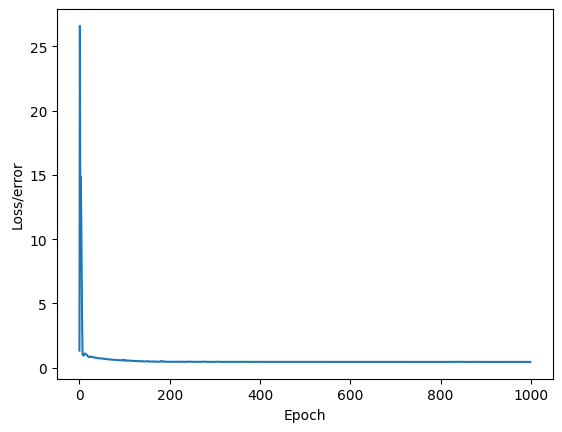

In [192]:
#lo graficamos 
plt.plot(range(epochs), losses)
plt.ylabel('Loss/error')
plt.xlabel('Epoch')

evaluamos el modelo en el set de prueba 

In [193]:
with torch.no_grad():
    # evaluamos el modelo en el set de prueba 
    y_eval = model.adelante(X_test)
    loss = criterion(y_eval, y_test.to(model.device))
    
    

In [194]:
loss

tensor(0.4572, device='cuda:0')

In [195]:
correctos = 0
with torch.no_grad():
    for i, data in enumerate(X_test):
        y_val = model.adelante(data)
        
        #nos va a decir la clase con mayor probabilidad
        print(f'{i+1}.) {str(y_val)  }\t \t  {y_test[i]}\t {y_val.argmax().item()}' )

        #averiguamos si es correcto o no
        if y_val.argmax().item() == y_test[i]:
            correctos += 1

print(f'El modelo tuvo {correctos} predicciones correctas de {len(y_test)} lo cual nos da un {(correctos/len(y_test))*100}% de efectividad')




1.) tensor([-5.9574,  1.2969,  3.7896], device='cuda:0')	 	  2	 2
2.) tensor([ 0.9764,  1.7527, -0.5089], device='cuda:0')	 	  1	 1
3.) tensor([-6.0691,  1.2895,  3.8588], device='cuda:0')	 	  2	 2
4.) tensor([-0.9712,  1.6257,  0.6992], device='cuda:0')	 	  1	 1
5.) tensor([-4.1430,  1.4165,  2.6650], device='cuda:0')	 	  2	 2
6.) tensor([-5.5165,  1.3260,  3.5164], device='cuda:0')	 	  2	 2
7.) tensor([-2.6908,  1.5123,  1.7650], device='cuda:0')	 	  2	 2
8.) tensor([-5.8843,  1.3017,  3.7443], device='cuda:0')	 	  2	 2
9.) tensor([ 1.3887,  1.6231, -0.8690], device='cuda:0')	 	  1	 1
10.) tensor([ 1.7103,  1.5221, -1.1498], device='cuda:0')	 	  0	 0
11.) tensor([-3.7296,  1.4438,  2.4088], device='cuda:0')	 	  2	 2
12.) tensor([ 1.5485,  1.5729, -1.0086], device='cuda:0')	 	  0	 1
13.) tensor([ 0.3044,  1.7098, -0.0914], device='cuda:0')	 	  1	 1
14.) tensor([-11.0153,   0.9633,   6.9245], device='cuda:0')	 	  2	 2
15.) tensor([-1.5377,  1.5884,  1.0503], device='cuda:0')	 	  1	 1
1